In [1]:
%load_ext autoreload
%autoreload 2
!source /home/murilo/RelNetCare/.env

In [2]:
from datasets import Dataset, DatasetDict
import os
import json
import torch
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_cap = -1
set_data = None
dataset_sets = {}
dict_sets = {}
# data_folder = "/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART"
# data_folder = "/home/murilo/RelNetCare/data/processed/dialog-re-babelscape-sredfm-llama-11cls-rebalPairs0.5x-rwrtKeys-instrC-mxTrnCp3-skpTps-BblscpSrdfm-prepBART"
data_folder = "/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART"

data_stem = data_folder.split('/')[-1]
base_model = 'facebook/bart-base'
model_path = f"/mnt/vdb1/murilo/models/fine-tuned/{base_model}/{data_stem}"

args_dict = {
    'memorization_task': False,
    'merge_train_dev': False
}


for set_ in ('train', 'test', 'dev'):

    data_path = os.path.join(data_folder, f'{set_}.json')

    with open(data_path, 'r') as f:
        data = json.load(f)
            
    # Remap keys and separate into train/test
    if args_dict['memorization_task']:
        if not set_data:
            set_data = [{"text": item["input"], "summary": item["output"], "title": ""} for item in data[data_cap:]]
    else:
        set_data = [{"text": item["input"], "summary": item["output"], "title": ""} for item in data]
        
    # Merge 'train' and 'dev' if the flag is set
    if args_dict['merge_train_dev']:
        if set_ == 'dev':
            dict_sets['train'] = dict_sets['train'] + set_data
        else:
           dict_sets[set_] = set_data
    else:
        dict_sets[set_] = set_data
        

    
for set_ in ('train', 'test', 'dev'):
    if args_dict['merge_train_dev']:
        if set_ == 'dev':
            continue
    set_data = dict_sets[set_]
    dataset_sets[set_] = Dataset.from_dict(
        {"text": [item["text"] for item in set_data],
         "summary": [item["summary"] for item in set_data],
         "title": [item["title"] for item in set_data]}
        )
    

# Create DatasetDict
dataset_dict = DatasetDict(dataset_sets)
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 2304
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 841
    })
    dev: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 705
    })
})

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm

# Specify your directory path

all_folders = [f for f in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, f))]

# If there's only one folder, set it as the checkpoint folder
if len(all_folders) == 1:
    checkpoint_folder = all_folders[0]
    full_checkpoint_path = os.path.join(model_path, checkpoint_folder)
    print(full_checkpoint_path)
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(full_checkpoint_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(full_checkpoint_path).to(device)
else:
    raise Exception("More than one checkpoint found. Be more specific!")

# Initialize an empty list to store raw_predicted_labels
raw_predicted_labels = []

# Loop through the test set
for entry in tqdm(dataset_dict['test']):
    text = entry['text']
    inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model.generate(inputs, max_length=300, do_sample=False)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    raw_predicted_labels.append(summary)

# Confirm the shape
assert len(raw_predicted_labels) == len(dataset_dict['test'])


/mnt/vdb1/murilo/models/fine-tuned/facebook/bart-base/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART/checkpoint-480

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /home/murilo/miniconda3/envs/llama-lora/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116_nocublaslt.so...
[2023-10-09 13:45:59,149] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!
  warn(msg)
100%|██████████| 841/841 [02:35<00:00,  5.42it/s]


In [4]:
raw_predicted_labels[:10]

['Speaker 5 is a parent of Speaker 1. Speaker 1 is a child of Speaker 5.',
 'Speaker 2 is a parent of Speaker 1. Speaker 1 is a child of Speaker 2.',
 'Speaker 2 is a parent of Speaker 3. Speaker 3 is a child of Speaker 2.',
 'Speaker 3 is a parent of Speaker 1. Speaker 1 is a child of Speaker 3.',
 'Speaker 1 is a sibling of Speaker 4. Speaker 4 is a parent of Speaker 1.',
 'Speaker 4 is a parent of Speaker 1. Speaker 1 is a child of Speaker 4.',
 'Speaker 4 is a parent of Speaker 1. Speaker 1 is a child of Speaker 4.',
 'Speaker 4 is a parent of Speaker 1. Speaker 1 is a child of Speaker 4.',
 'Speaker 4 is a parent of Speaker 1. Speaker 1 is a child of Speaker 4.',
 'Speaker 4 is a parent of Speaker 6. Speaker 6 is a child of Speaker 4.']

In [5]:
from src.processing.bart_processing import RelationConverter
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

def convert_raw_labels_to_relations(raw_predicted_labels, input_path=''):
    converter = RelationConverter(input_path=input_path)
    predicted_labels = []
    error_count = 0  # Initialize error counter
    errors = []
    for raw_label in tqdm(raw_predicted_labels):
        label_relations = []
        if raw_label:
            for sent in sent_tokenize(raw_label): 
                try:
                    sub, rel, obj = converter._convert_sentence_to_relation(sent[:-1] if sent.endswith('.') else sent)
                except Exception as e:
                    sub, rel, obj = ("ERROR", "ERROR", "ERROR")
                    error = f'Exception `{e}` with sentence below:\n`{sent}`'
                    errors.append(error)
                    error_count += 1  # Increment error counter
                label_relations.append({'subject': sub, 'relation': rel, 'object': obj})

        predicted_labels.append(label_relations)

    # Confirm the shape
    assert len(raw_predicted_labels) == len(predicted_labels)
    
    # Print out the error ratio
    total_samples = len(raw_predicted_labels)
    error_ratio = (error_count / total_samples) * 100
    print(f'Errors: {error_count}/{total_samples} ({error_ratio:.2f}%)')

    return predicted_labels, errors  # Return tuple with predicted_labels and error_count

# Usage
predicted_labels, pred_errors = convert_raw_labels_to_relations(raw_predicted_labels)
print(predicted_labels[:3])


[nltk_data] Downloading package punkt to /home/murilo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Initialized with input path: 
Output path set to         : -prepBART


100%|██████████| 841/841 [00:00<00:00, 20152.02it/s]

Errors: 7/841 (0.83%)
[[{'subject': 'Speaker 5', 'relation': 'parents', 'object': 'Speaker 1'}, {'subject': 'Speaker 1', 'relation': 'children', 'object': 'Speaker 5'}], [{'subject': 'Speaker 2', 'relation': 'parents', 'object': 'Speaker 1'}, {'subject': 'Speaker 1', 'relation': 'children', 'object': 'Speaker 2'}], [{'subject': 'Speaker 2', 'relation': 'parents', 'object': 'Speaker 3'}, {'subject': 'Speaker 3', 'relation': 'children', 'object': 'Speaker 2'}]]


In [6]:
true_labels, true_errors = convert_raw_labels_to_relations(dataset_dict['test']['summary'])

Initialized with input path: 
Output path set to         : -prepBART


  0%|          | 0/841 [00:00<?, ?it/s]

100%|██████████| 841/841 [00:00<00:00, 26344.01it/s]

Errors: 0/841 (0.00%)


In [7]:
from src.processing.relation_extraction_evaluator import RelationExtractorEvaluator, RelationGranularMetrics
from src.config import get_config_from_stem
config = get_config_from_stem(data_stem)
evaluator = RelationExtractorEvaluator(config=config)
df = evaluator.assess_performance_on_lists(
    true_labels_list=true_labels, pred_labels_list=predicted_labels, return_details=True,
    # output_path=f'/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART/{base_model}'
    )
df

output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-trToDial-rwrtKeys-instrA
self.skip_types=True, forcing intruction_type to `C`...
output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-balPairs-rebalPairs-rwrtKeys-instrC-skpTps
Not output_path provided, nothing dump!
# INFERENCE REPORT
None



,id,prompt,dialogue,true_labels,raw_inference,predicted_labels,correct_labels,wrong_labels,missing_labels,f1s,precision,recall,error_message
0,1,,None,"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 5"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Montauk"",\n ""relation"": ...",0.0,0.0,0.0,
1,2,,None,[],None,"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],0.0,0.0,0.0,
2,3,,None,[],None,"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],0.0,0.0,0.0,
3,4,,None,[],None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],0.0,0.0,0.0,
4,5,,None,[],None,"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...",[],0.0,0.0,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,837,,None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],[],1.0,1.0,1.0,
837,838,,None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",0.0,0.0,0.0,
838,839,,None,"[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...","[\n {\n ""subject"": ""New York"",\n ""relation"":...",0.0,0.0,0.0,
839,840,,None,"[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],"[\n {\n ""subject"": ""New York"",\n ""relation"":...","[\n {\n ""subject"": ""New York"",\n ""relation"":...",0.0,0.0,0.0,


['place_of_residence',
 'residents_of_place',
 'siblings',
 'spouse',
 'other_family',
 'pet',
 'children',
 'parents',
 'acquaintance',
 'visited_place',
 'visitors_of_place']

output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-trToDial-rwrtKeys-instrA


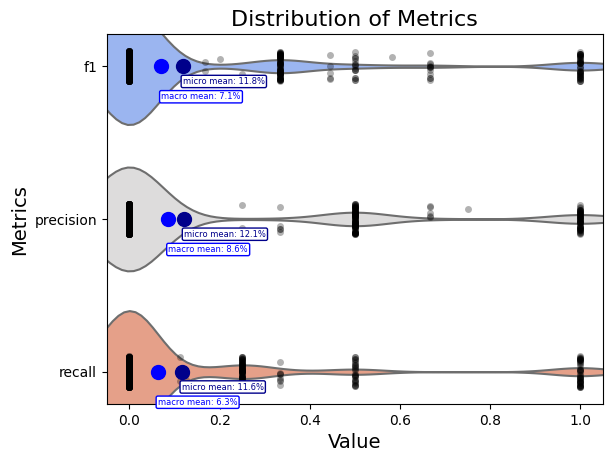

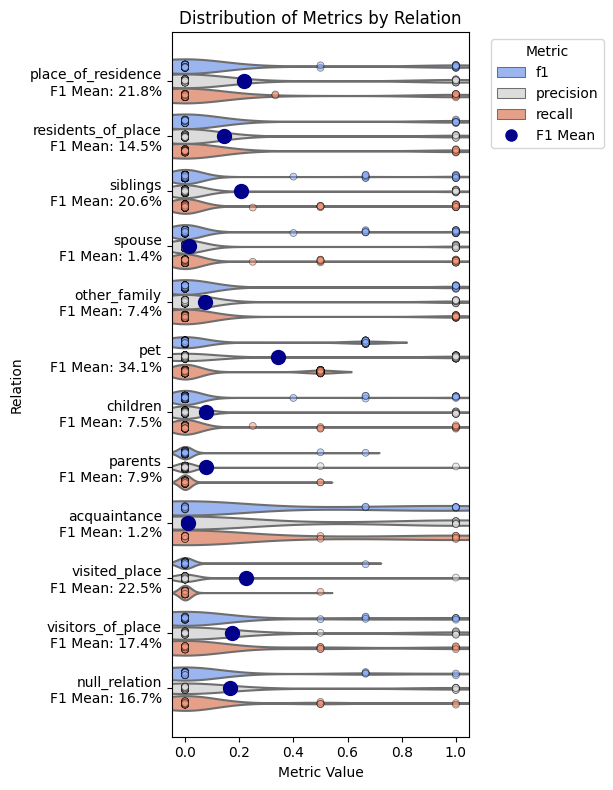

In [239]:
from src.processing.relation_extraction_evaluator import GranularMetricVisualizer
metric_visualizer = GranularMetricVisualizer(df=df, model_name=base_model, test_dataset_stem=data_stem)
metric_visualizer.visualize_class_metrics_distribution(df)
df_metrics_sample = metric_visualizer.visualize_class_metrics_distribution_per_class(df)
output_metrics = metric_visualizer.dump_metrics()


In [238]:
metric_visualizer.df['failure_modes'].iloc[0]

{'place_of_residence': {'list': {'tp': [],
   'fp': [],
   'tn': [],
   'fn': ["{'subject': 'Speaker 1', 'relation': 'place_of_residence', 'object': 'Montauk'}"]},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 1}},
 'residents_of_place': {'list': {'tp': [],
   'fp': [],
   'tn': [],
   'fn': ["{'subject': 'Montauk', 'relation': 'residents_of_place', 'object': 'Speaker 1'}"]},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 1}},
 'siblings': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'spouse': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'other_family': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'pet': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'children': {'list': {'tp': [],
   'fp': ["{'subject': 'Speaker 1', 'relation': 'children', 'object': 'Speaker 5

In [235]:
mask = metric_visualizer.df.apply(lambda x: (x['true_labels'] == []) &  (x['predicted_labels'] == []), axis=1)
metric_visualizer.df[mask]#['failure_modes'].iloc[0]

,id,prompt,dialogue,true_labels,raw_inference,predicted_labels,correct_labels,wrong_labels,missing_labels,f1s,precision,recall,error_message,true_labels_str,predicted_labels_str,failure_modes,metrics
43,44,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}
52,53,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}
53,54,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}
54,55,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}
55,56,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}
66,67,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}
121,122,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}
123,124,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}
126,127,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}
138,139,,None,[],None,[],[],[],[],1.0,1.0,1.0,,[],[],"{'place_of_residence': {'list': {'tp': [], 'fp...",{}


In [234]:
metric_visualizer.df['f1s'].max()

1.0

In [211]:
(metric_visualizer.df['f1s'].astype(int) == 1).sum()

0

In [206]:
import pandas as pd


		

In [203]:
metric_visualizer.df.failure_modes.iloc[9]

{'place_of_residence': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'residents_of_place': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'siblings': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'spouse': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'other_family': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'pet': {'list': {'tp': [], 'fp': [], 'tn': [], 'fn': []},
  'counts': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}},
 'children': {'list': {'tp': [],
   'fp': ["{'subject': 'Speaker 6', 'relation': 'children', 'object': 'Speaker 4'}"],
   'tn': [],
   'fn': []},
  'counts': {'tp': 0, 'fp': 1, 'tn': 0, 'fn': 0}},
 'parents': {'list': {'tp': [],
   'fp': ["{'subject': 'Speaker 4', 'relation': 'parents', 'obje

In [200]:
output_metrics = metric_visualizer.dump_metrics()


output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-trToDial-rwrtKeys-instrA


In [107]:
df_metrics_sample['f1'].value_counts()

f1
0.000000    9217
1.000000     563
0.666667     287
0.500000      22
0.400000       3
Name: count, dtype: int64

In [182]:
from src.processing.relation_extraction_evaluator import GranularMetricVisualizer
metric_visualizer = GranularMetricVisualizer(df=df, model_name=base_model, test_dataset_stem=data_stem)
# output_metrics = metric_visualizer.dump_metrics(df_metrics_sample)
# output =  metric_visualizer.compute_metrics(df)
# output

output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-trToDial-rwrtKeys-instrA


{'precision': 0, 'recall': 0, 'f1': 0}

In [185]:
metric_visualizer.metrics['per_class']

{'place_of_residence': {'precision': 0.18571428571428572,
  'recall': 0.2653061224489796,
  'f1': 0.21848739495798322},
 'residents_of_place': {'precision': 0.13114754098360656,
  'recall': 0.16326530612244897,
  'f1': 0.14545454545454545},
 'siblings': {'precision': 0.2166172106824926,
  'recall': 0.19623655913978494,
  'f1': 0.2059238363892807},
 'spouse': {'precision': 0.05128205128205128,
  'recall': 0.00819672131147541,
  'f1': 0.014134275618374558},
 'other_family': {'precision': 0.046153846153846156,
  'recall': 0.18461538461538463,
  'f1': 0.07384615384615385},
 'pet': {'precision': 0.5,
  'recall': 0.25925925925925924,
  'f1': 0.3414634146341463},
 'children': {'precision': 0.05934718100890208,
  'recall': 0.10362694300518134,
  'f1': 0.07547169811320754},
 'parents': {'precision': 0.06,
  'recall': 0.11428571428571428,
  'f1': 0.07868852459016394},
 'acquaintance': {'precision': 0.07692307692307693,
  'recall': 0.006493506493506494,
  'f1': 0.01197604790419162},
 'visited_pla

In [154]:
relations

['place_of_residence',
 'residents_of_place',
 'siblings',
 'spouse',
 'other_family',
 'pet',
 'children',
 'parents',
 'acquaintance',
 'visited_place',
 'visitors_of_place',
 'no_relation']

In [173]:
# row = {}
# row['true_labels'] = \
# [{'subject': 'Speaker 2', 'relation': 'siblings', 'object': 'Speaker 1'}, # correct!
#  {'subject': 'Speaker 1', 'relation': 'siblings', 'object': 'Speaker 2'}] # false!


# row['predicted_labels'] = \
# [{'subject': 'Speaker 2', 'relation': 'siblings', 'object': 'Speaker 1'}, # correct
#  {'subject': 'Speaker 1', 'relation': 'other_family', 'object': 'Speaker 2'}] #false

# def compute_failure_modes(row, relations):
#     output = {}
#     true_label_dicts = row['true_labels']
#     pred_label_dicts = row['predicted_labels']

#     true_labels_str = [str(l) for l in true_label_dicts] if true_label_dicts else ['no_relation']
#     pred_labels_str = [str(l) for l in pred_label_dicts] if pred_label_dicts else ['no_relation']
    
#     for r in relations:
#         true_labels_with_rel = [l for l in true_labels_str if r in l]
#         pred_labels_with_rel = [l for l in pred_labels_str if r in l]
        
#         tp_list = [l for l in true_labels_with_rel if l in pred_labels_with_rel]
#         fp_list = [l for l in pred_labels_with_rel if l not in true_labels_with_rel]
#         fn_list = [l for l in true_labels_with_rel if l not in pred_labels_with_rel]
#         tn_list = [l for l in pred_labels_with_rel if l not in fp_list]  # Tweaked this line

#         output[r] = {
#             'list': {
#                 'tp': tp_list,
#                 'fp': fp_list,
#                 'tn': tn_list,  # Also tweaked this
#                 'fn': fn_list
#             },
#             'counts': {
#                 'tp': len(tp_list),
#                 'fp': len(fp_list),
#                 'tn': len(tn_list),  # And this
#                 'fn': len(fn_list),
#             }
#         }
#     return output

# relations = df.true_labels.apply(lambda rels: [r['relation'] for r in rels]).explode().dropna().unique().tolist() + ['no_relation']

# compute_failure_modes(row, relations)

In [172]:
# df['failure_modes'] = df.apply(compute_failure_modes, relations=relations, axis=1)

In [171]:
# df['failure_modes'].iloc[0]

In [170]:
# from collections import defaultdict

# def calculate_metrics(failure_modes_df):
#     # Initialize sums for micro-average
#     micro_sum = defaultdict(int)
    
#     # Initialize lists for macro-average
#     macro_precision = []
#     macro_recall = []
#     macro_f1 = []

#     for row in failure_modes_df:
#         for rel, data in row.items():
#             tp = data['counts']['tp']
#             fp = data['counts']['fp']
#             fn = data['counts']['fn']
            
#             # Sum counts for micro-average
#             micro_sum['tp'] += tp
#             micro_sum['fp'] += fp
#             micro_sum['fn'] += fn
            
#             # Calculate per-relation metrics
#             if tp + fp == 0:
#                 precision = 0
#             else:
#                 precision = tp / (tp + fp)
            
#             if tp + fn == 0:
#                 recall = 0
#             else:
#                 recall = tp / (tp + fn)
            
#             if precision + recall == 0:
#                 f1 = 0
#             else:
#                 f1 = 2 * (precision * recall) / (precision + recall)
            
#             # Append to lists for macro-average
#             macro_precision.append(precision)
#             macro_recall.append(recall)
#             macro_f1.append(f1)

#     # Micro-average
#     micro_precision = micro_sum['tp'] / (micro_sum['tp'] + micro_sum['fp'])
#     micro_recall = micro_sum['tp'] / (micro_sum['tp'] + micro_sum['fn'])
#     micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    
#     # Macro-average
#     macro_precision = sum(macro_precision) / len(macro_precision)
#     macro_recall = sum(macro_recall) / len(macro_recall)
#     macro_f1 = sum(macro_f1) / len(macro_f1)
    
#     return { 'micro_avg':
#         {'precision': micro_precision,
#         'recall': micro_recall,
#         'f1': micro_f1},
#         'macro_avg':
#         {'precision': macro_precision,
#         'recall': macro_recall,
#         'f1': macro_f1}}

# # Assume failure_modes_df is your dataframe converted to a list of dictionaries
# result = calculate_metrics(df['failure_modes'])
# result

In [168]:
# from collections import defaultdict

# def calculate_per_class_metrics(failure_modes_df):
#     class_metrics = defaultdict(lambda: defaultdict(int))

#     for row in failure_modes_df:
#         for rel, data in row.items():
#             tp = data['counts']['tp']
#             fp = data['counts']['fp']
#             fn = data['counts']['fn']
            
#             # Update class-specific metrics
#             class_metrics[rel]['tp'] += tp
#             class_metrics[rel]['fp'] += fp
#             class_metrics[rel]['fn'] += fn

#     # Calculate the final metrics for each class
#     final_class_metrics = {}
#     for rel, counts in class_metrics.items():
#         tp = counts['tp']
#         fp = counts['fp']
#         fn = counts['fn']
        
#         if tp + fp == 0:
#             precision = 0
#         else:
#             precision = tp / (tp + fp)
            
#         if tp + fn == 0:
#             recall = 0
#         else:
#             recall = tp / (tp + fn)
            
#         if precision + recall == 0:
#             f1 = 0
#         else:
#             f1 = 2 * (precision * recall) / (precision + recall)
        
#         final_class_metrics[rel] = {
#             'Precision': precision,
#             'Recall': recall,
#             'F1 Score': f1
#         }

#     return final_class_metrics

# # Assume failure_modes_df is your dataframe converted to a list of dictionaries
# result = calculate_per_class_metrics(df['failure_modes'])
# result

output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-trToDial-rwrtKeys-instrA


In [169]:
# # Test Data
# test_cases = [
#     {
#         'name': 'Test Case 1',
#         'input': {
#             'true_labels': [
#                 {'subject': 'S1', 'relation': 'siblings', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'siblings', 'object': 'S1'},
#             ],
#             'predicted_labels': [
#                 {'subject': 'S1', 'relation': 'siblings', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'siblings', 'object': 'S1'},
#             ]
#         },
#         'expected': {'siblings': {'tp': 2, 'fp': 0, 'tn': 0, 'fn': 0}}
#     },
#     {
#         'name': 'Test Case 2',
#         'input': {
#             'true_labels': [
#                 {'subject': 'S1', 'relation': 'siblings', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'siblings', 'object': 'S1'},
#             ],
#             'predicted_labels': [
#                 {'subject': 'S1', 'relation': 'other_family', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'other_family', 'object': 'S1'},
#             ]
#         },
#         'expected': {'siblings': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 2},
#                      'other_family': {'tp': 0, 'fp': 2, 'tn': 0, 'fn': 0}}
#     },
#     {
#         'name': 'Test Case 3',
#         'input': {
#             'true_labels': [
#                 {'subject': 'S1', 'relation': 'siblings', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'siblings', 'object': 'S1'},
#             ],
#             'predicted_labels': [
#                 {'subject': 'S1', 'relation': 'siblings', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'other_family', 'object': 'S1'},
#             ]
#         },
#         'expected': {'siblings': {'tp': 1, 'fp': 0, 'tn': 0, 'fn': 1},
#                      'other_family': {'tp': 0, 'fp': 1, 'tn': 0, 'fn': 0}}
#     }
# ]

# # ... Previous test cases ...

# test_cases += [
#     {
#         'name': 'Test Case 4',
#         'input': {
#             'true_labels': [
#                 {'subject': 'S1', 'relation': 'siblings', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'siblings', 'object': 'S1'},
#             ],
#             'predicted_labels': []
#         },
#         'expected': {'siblings': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 2}}
#     },
#     {
#         'name': 'Test Case 5',
#         'input': {
#             'true_labels': [],
#             'predicted_labels': [
#                 {'subject': 'S1', 'relation': 'siblings', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'siblings', 'object': 'S1'},
#             ]
#         },
#         'expected': {'siblings': {'tp': 0, 'fp': 2, 'tn': 0, 'fn': 0}}
#     },
#     {
#         'name': 'Test Case 6',
#         'input': {
#             'true_labels': [],
#             'predicted_labels': []
#         },
#         'expected': {}  # No relations, hence empty dictionary.
#     },
#     {
#         'name': 'Test Case 7',
#         'input': {
#             'true_labels': [
#                 {'subject': 'S1', 'relation': 'siblings', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'other_family', 'object': 'S3'},
#                 {'subject': 'S2', 'relation': 'other_family', 'object': 'S4'},
#                 {'subject': 'S1', 'relation': 'friends', 'object': 'S4'}
#             ],
#             'predicted_labels': [
#                 {'subject': 'S1', 'relation': 'siblings', 'object': 'S2'},
#                 {'subject': 'S2', 'relation': 'other_family', 'object': 'S3'},
#                 {'subject': 'S2', 'relation': 'friends', 'object': 'S4'},
#                 {'subject': 'S1', 'relation': 'friends', 'object': 'S4'}
#             ]
#         },
#         'expected': {
#             'siblings': {'tp': 1, 'fp': 0, 'tn': 0, 'fn': 0},
#             'other_family': {'tp': 1, 'fp': 0, 'tn': 0, 'fn': 1},
#             'friends': {'tp': 1, 'fp': 1, 'tn': 0, 'fn': 0}
#         }
#     }
# ]

# # ... Run Tests ...


# # Run Tests
# for test in test_cases:
#     result = compute_failure_modes(test['input'])
#     assert result == test['expected'], f"{test['name']} failed!"
#     print(f"{test['name']} passed!")


In [135]:
test['expected']

{'siblings': {'tp': 2, 'fp': 0, 'tn': 0, 'fn': 0}}

In [132]:
result

{'siblings': {'tp_list': ["{'subject': 'S1', 'relation': 'siblings', 'object': 'S2'}",
   "{'subject': 'S2', 'relation': 'siblings', 'object': 'S1'}"],
  'fp_list': [],
  'tn_list': [],
  'fn_list': [],
  'tp_count': 2,
  'fp_count': 0,
  'tn_count': 0,
  'fn_count': 0}}

In [121]:
relations

{'place_of_residence', 'residents_of_place'}

In [127]:
df[df.f1s > 0].iloc[0].true_labels

[{'subject': 'Speaker 2', 'relation': 'siblings', 'object': 'Speaker 1'},
 {'subject': 'Speaker 1', 'relation': 'siblings', 'object': 'Speaker 2'}]

In [128]:
df[df.f1s > 0].iloc[0].predicted_labels


[{'subject': 'Speaker 2', 'relation': 'siblings', 'object': 'Speaker 1'},
 {'subject': 'Speaker 1', 'relation': 'other_family', 'object': 'Speaker 2'}]

In [54]:
df.correct_labels.explode().dropna().map(lambda x: x['relation']).value_counts()

correct_labels
siblings              73
parents               24
children              20
place_of_residence    13
other_family          12
visited_place          8
residents_of_place     8
pet                    7
visitors_of_place      6
spouse                 2
acquaintance           1
Name: count, dtype: int64

In [15]:
# # Release GPU
model.cpu()
del model
torch.cuda.empty_cache()
